# <font color =green>Forest Fire Detection Using CNN based on Transfer Learning</font>

### The contenets of this notebook are divided into following sections <br>
***
1. <font colour =red> Data Loading and Pre-Processing </font>  [link](#Data_Loding_and_Processing)<br>
2.Model Creation and Training  [link](#Model_creation)<br>
3.Fine Tuning of the model  [link](#Fine_tuning)<br>

In [14]:
# Importing all required Libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import seaborn as sns
import pandas as pd 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from keras import optimizers


#### Configuring TPU for Usage

In [15]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(tpu_strategy)
print("No of tpu replicas Available:",tpu_strategy.num_replicas_in_sync)

No of tpu replicas Available: 8


In [16]:
Data_loading_debug       = False 
Model_creation_debug     = False
Fine_tuning_debug        = False

## Data Loading and Pre-Processing
<a id = "Data_Loding_and_Processing"></a>

Images are loaded into TPU data sets for faster processing. Each Bacth of images are divided into sets of no of tpu replicas and loded into one replica for parallel processing. The functions defined in this Section are follows
* Images paths extraction and labels addition
* Decodong of images using tensor flow(Parse images Function)
* Random Augmentation of data
* TF datasets creation

In [17]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('forest-fires-classification')
print(GCS_DS_PATH)

gs://kds-6ff8496768ae10ffb98b20ec1e1d22c582884e69dfe23c86459754c1


In [18]:
# Defining the folder paths for different classes of both Training and test and key values for the classes
Fire_Train_images_dict = {
                            'Fire' : "/kaggle/input/forest-fires-classification/Training/Training/Fire",
                            'No_fire' : "/kaggle/input/forest-fires-classification/Training/Training/No_Fire"
                         }

Fire_Test_images_dict =  {
                            'Fire' : "/kaggle/input/forest-fires-classification/Test/Test/Fire",
                            'No_fire' : "/kaggle/input/forest-fires-classification/Test/Test/No_Fire"
                         }

Fire_labels_dict =       {
                            'Fire' : 1,
                            'No_fire':0
                         }

In [19]:
# Loading train image paths and adding labels to them 
train_image_paths  = []       
train_labels       = []  

for dirs,values in Fire_Train_images_dict.items():
    
    temp = values.split('/')
    New_paths = GCS_DS_PATH+'/'+temp[-3]+'/'+temp[-2]+'/'+temp[-1]
    if Data_loading_debug == True:
        
        print("New train paths after GCS link additin is: ",New_paths)
    
    for dirname, _, filenames in os.walk(values):
        
        count = 0
        for filename in filenames:
            
            count += 1 
            train_image_paths.append(str(New_paths+'/'+filename)) 
            train_labels.append(Fire_labels_dict[str(dirs)])
            
        print("No of train samples found for label ", dirs, count)

No of train samples found for label  Fire 25018
No of train samples found for label  No_fire 20365


In [20]:
#Loading test image paths and adding labels to them
test_image_paths = []
test_labels      = []      
for dirs,values in Fire_Test_images_dict.items():
    
    temp = values.split('/')
    New_paths = GCS_DS_PATH+'/'+temp[-3]+'/'+temp[-2]+'/'+temp[-1]
    if Data_loading_debug == True:
        
        print("New test paths after GCS link additin is :",New_paths)
    
    for dirname, _, filenames in os.walk(values):
        
        count = 0
        for filename in filenames:
            
            count +=1
            test_image_paths.append(str(New_paths+'/'+filename))
            test_labels.append(Fire_labels_dict[str(dirs)])
            
        print("No of test samples found for label ", dirs, count)
        

No of test samples found for label  Fire 5137
No of test samples found for label  No_fire 3480


In [21]:
# Creating a Pandas Data frame for shuffling the data and performring the stratified train test split
data = pd.DataFrame(columns=["image_names","labels"])
data.image_names = train_image_paths
data.labels = train_labels

In [22]:
Train_paths, Validation_paths, Train_labels, Validation_labels = train_test_split(
                                                                                  data.image_names, 
                                                                                  data.labels,
                                                                                  stratify=data.labels, 
                                                                                  test_size=0.15
                                                                                 )

In [23]:
BATCH_SIZE = 64 * tpu_strategy.num_replicas_in_sync

In [24]:
def parse_images(filename,label = None):
    """
    The function expects filesnames of images to read along with labels for ziping them if labels are given as none then only images are returned
    Images are read using tesnorflow io functins and the images decoded into byte format then casted and resized
    """
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.image.resize(image, [254, 254])
    return image if label is None else image, label

In [25]:
def augment_images(image_label, seed):
    """
    The function expects a pair of image and label along with seed used for random augmentation application.
    The augmentations are grouped into three sets they are follows 
        1. Contrast and Saturation
        2. Brightness and Hue
        3. Horizontal and vertical flips
    Using group is assigned with a random propability genrated. if the propabality is less than 0.2 then one of the augmentatios in that group is applied. 
    So every has chance of one augmentation at leasr from all three groups applied or no augmentations applied as well
    """
    
    image, label = image_label
    image, label = parse_images(image, label)
    p_augment_CS = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_augment_RF = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_augment_BH = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_augment_BH <0.1:
        image= tf.image.stateless_random_brightness(image, 0.2, seed)
    elif p_augment_BH >0.1 and p_augment_BH < 0.2:
        image = tf.image.stateless_random_hue(image, 0.2, seed)
    else:
        image = image
    if p_augment_CS < 0.1:
        image = tf.image.stateless_random_contrast(image, 0.2, 0.5, seed)
    elif p_augment_CS >0.1 and p_augment_CS < 0.2:
        image = tf.image.stateless_random_saturation(image, 0.0, 0.9, seed)
    else:
        image = image
    if p_augment_RF < 0.1:
        image = tf.image.stateless_random_flip_left_right(image, seed)
    elif p_augment_RF  < 0.1 and p_augment_RF < 0.2:
        image = tf.image.stateless_random_flip_up_down(image, seed)
    else:
        image = image
    return image, label

In [26]:
rng = tf.random.Generator.from_seed(123, alg='philox')
def Random_augmentation(x,y):
    """
    Random augment function generates random seed for every image and calls the augment_images functions for applying the selected augmentation based on seed assigned 
    """
    seed = rng.make_seeds(2)[0] 
    image, label = augment_images((x,y), seed)
    return image, label

In [27]:
def load_dataset(filenames, labels=None, repeat=True, shuffle=True,augment = True):
    """
    The load_dataset function loads the images and batches them into tf.dataset format
    Along with file names and labels it accepts various other flags like repeat , shuffel to specify whether to repeat data in batches and shuffle data while batching
    This function returns a Tensor flow dataset
    """
    AUTO = tf.data.experimental.AUTOTUNE
    slices = filenames if labels is None else (filenames,labels)
    counter = tf.data.experimental.Counter()
    dataset = tf.data.Dataset.from_tensor_slices(slices) # automatically interleaves reads from multiple files # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(parse_images, num_parallel_calls=AUTO) if not augment else dataset.map(Random_augmentation, num_parallel_calls=AUTO)
    dataset = dataset if not repeat else dataset.repeat()
    dataset = dataset if not shuffle else dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)
    return dataset

In [28]:
#Loading of Training and validation data
Train_data = load_dataset(Train_paths,Train_labels,False,True,False)
validation_data = load_dataset(Validation_paths,Validation_labels,False,True,False)

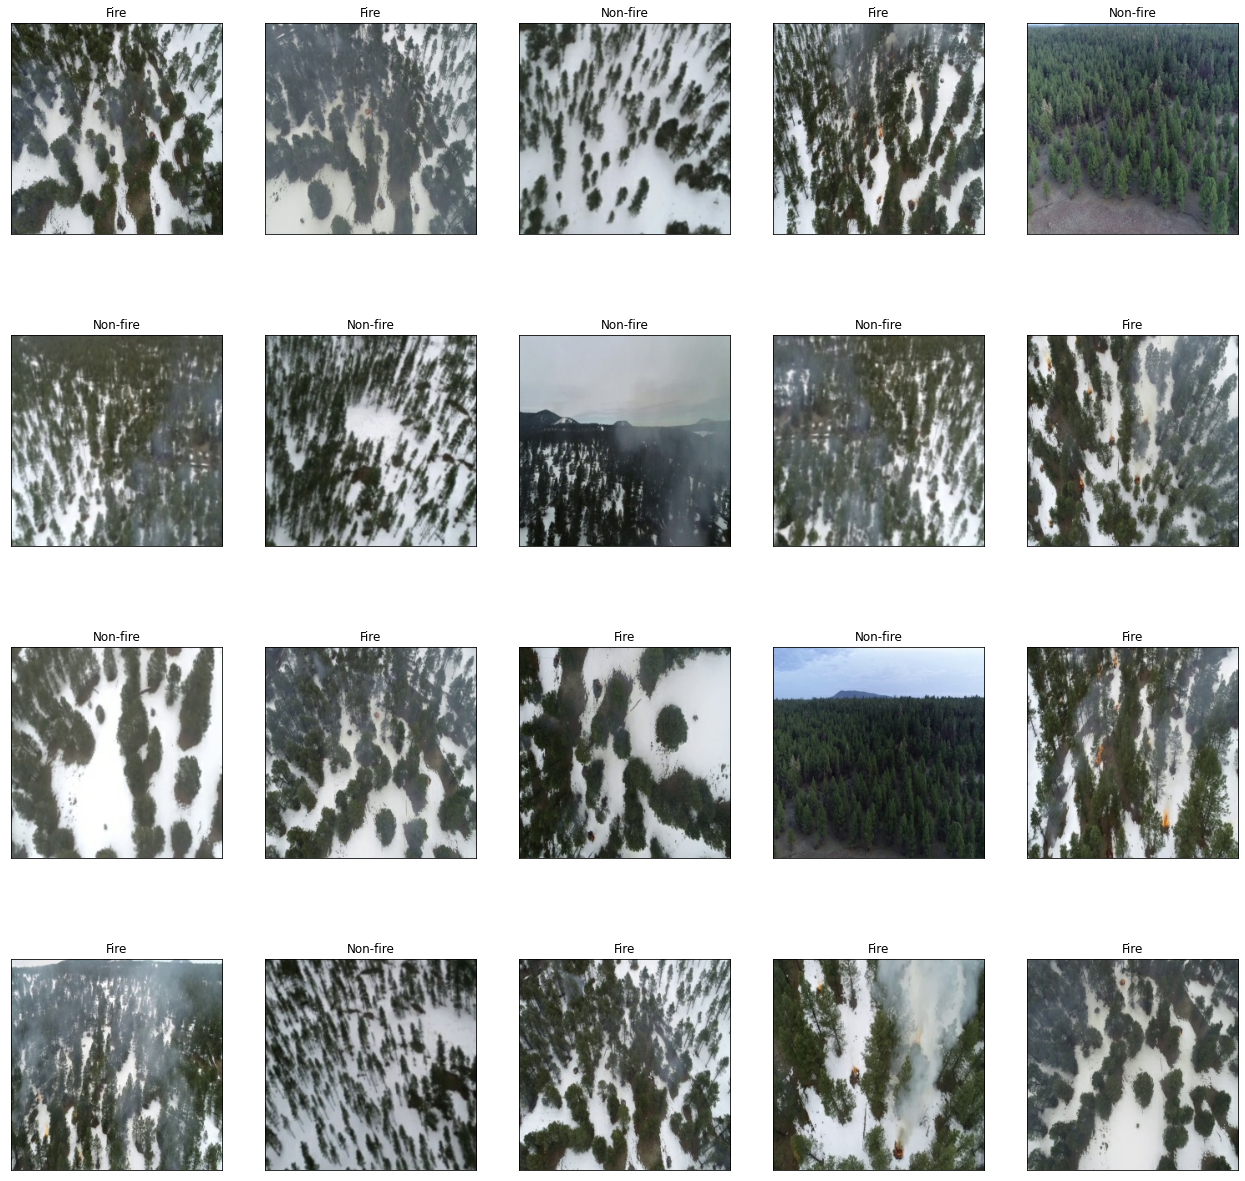

In [29]:
#Visualization of some train images loaded into a random batch
image, label = next(iter(Train_data))
image = image.numpy()
label = label.numpy()
enum = ['Non-fire','Fire']
fig = plt.figure(figsize=(22, 22))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image[i])
    title = enum[label[i]]
    ax.set_title(title)

In [30]:
#Loading of Testing data
Test_data = load_dataset(test_image_paths,test_labels,False,False,False)

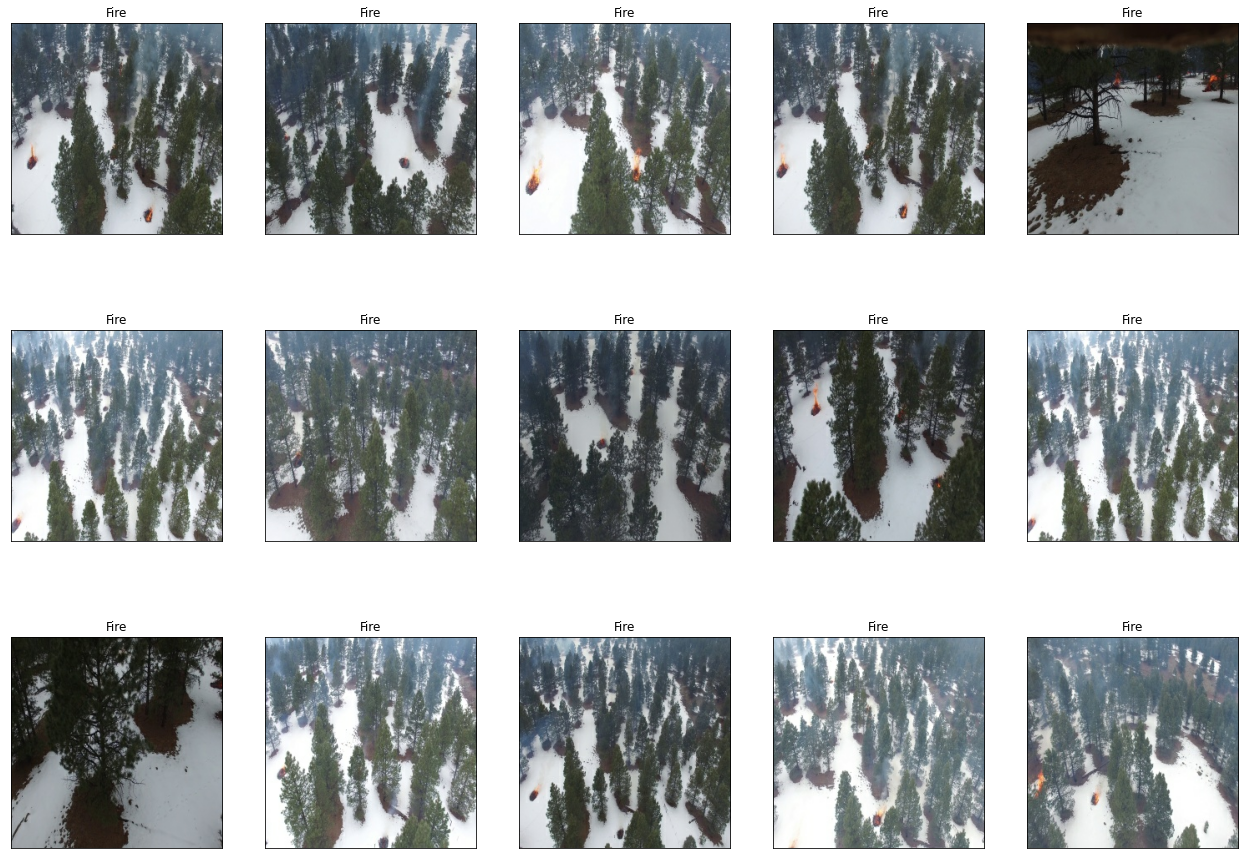

In [31]:
#Visualization of some train images loaded into a random batch
image, label = next(iter(Test_data))
image = image.numpy()
label = label.numpy()
fig = plt.figure(figsize=(22, 16))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image[i])
    title = enum[label[i]]
    ax.set_title(title)

## Model Creation
<a id = "Model_creation"></a>

Transfer Learning Techniques are utilized to develop a model using the pretrained Xception Model. In this step the Xception model is utilized for feature extraction.The steps performed in this section are as follows
* Model creation with TPU stategy 
* Defing call backs for training of model
* Training the model
* visulization of results


In [32]:
#Importing the keras applications and deep neural network libraries
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Input, Flatten,GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [33]:
# Defing and developing the transfer learning model in TPU scope
with tpu_strategy.scope():
    img_input = Input(shape=(254,254,3))
    pre_trained_model = Xception(include_top=False,
    weights="imagenet",
    input_shape=(254,254,3),
    input_tensor=img_input)
    pre_trained_model.trainable = False
    x = pre_trained_model.output
    x = GlobalAveragePooling2D()(x) # Flatten dimensions to for use in FC layers
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [34]:
# Debugging the model architecture and layers 
if Model_creation_debug == True:
    model.summary()
    for i,layer in enumerate(model.layers):
        print(i,layer.name,layer.trainable)

In [35]:
# Defing the required callbacks for the model training
early_stopping = EarlyStopping(
                                    monitor="val_loss",
                                    min_delta=1e-5,
                                    patience=5,
                                    verbose=1,
                                    mode="min",
                                    restore_best_weights=True,
                              )
reduce_learn_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    factor=0.2,
                                    patience=5,
                                    mode="min",
                                    min_delta=0.0001
                                    )

check_point = ModelCheckpoint(
                                    filepath="XceptionWeights.{epoch:02d}.h5",
                                    monitor="val_loss",
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode="min"
                             )
my_callbacks = [early_stopping,reduce_learn_rate,check_point]

In [36]:
# Training of the model with Xception layers frozen
history = model.fit(Train_data,epochs=10, validation_data =validation_data,callbacks = my_callbacks)

Epoch 1/10
75/75 [==============================] - 1597s 21s/step - loss: 0.4336 - acc: 0.7925 - val_loss: 0.1485 - val_acc: 0.9668

Epoch 00001: val_loss improved from inf to 0.14852, saving model to XceptionWeights.01.h5
Epoch 2/10
75/75 [==============================] - 968s 13s/step - loss: 0.1348 - acc: 0.9667 - val_loss: 0.0990 - val_acc: 0.9748

Epoch 00002: val_loss improved from 0.14852 to 0.09896, saving model to XceptionWeights.02.h5
Epoch 3/10
75/75 [==============================] - 968s 13s/step - loss: 0.0953 - acc: 0.9759 - val_loss: 0.0773 - val_acc: 0.9805

Epoch 00003: val_loss improved from 0.09896 to 0.07727, saving model to XceptionWeights.03.h5
Epoch 4/10
75/75 [==============================] - 969s 13s/step - loss: 0.0765 - acc: 0.9797 - val_loss: 0.0646 - val_acc: 0.9835

Epoch 00004: val_loss improved from 0.07727 to 0.06464, saving model to XceptionWeights.04.h5
Epoch 5/10
75/75 [==============================] - 961s 13s/step - loss: 0.0656 - acc: 0.9820 

Accuracy before fine tuning


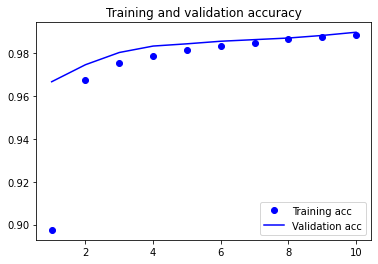

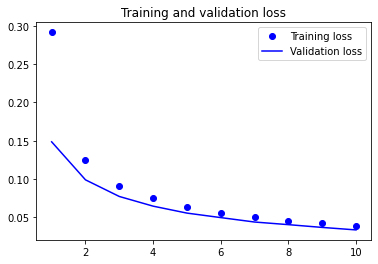

In [37]:
#Visualization of the training results
print("Accuracy before fine tuning")

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("Training_Validation_acc")

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("Training_Validation_loss")

plt.show()

In [39]:
#Evaluating the trained model
model.evaluate(Test_data)

16/16 [==============================] - 331s 20s/step - loss: 0.5892 - acc: 0.7216


[0.589192271232605, 0.7215576171875]

In [40]:
#saving the model
model.save('Feature_extraction_Xception.h5')

## Fine Tuning of Xception
<a id = "Fine_tuning"></a>

In this section the pre trained model which is working in feature mode is now fine tuned to better fit the model and obtain better accuracy on Test data

In [41]:
# unfrezzing the Xception layers for fine tuning
with tpu_strategy.scope():
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(
                  optimizer=keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['acc']
                 )
    

In [42]:
if Fine_tuning_debug== True:
    model.summary()
    for i,layer in enumerate(model.layers):
        print(i,layer.name,layer.trainable)

In [43]:
#Fine tuning the model
history_FT = model.fit(Train_data,epochs=5, validation_data =validation_data,callbacks = my_callbacks)

Epoch 1/5
75/75 [==============================] - 1040s 13s/step - loss: 0.0193 - acc: 0.9935 - val_loss: 0.0034 - val_acc: 0.9991

Epoch 00001: val_loss improved from 0.03364 to 0.00340, saving model to XceptionWeights.01.h5
Epoch 2/5
75/75 [==============================] - 1033s 13s/step - loss: 0.0040 - acc: 0.9984 - val_loss: 0.0012 - val_acc: 0.9998

Epoch 00002: val_loss improved from 0.00340 to 0.00124, saving model to XceptionWeights.02.h5
Epoch 3/5
75/75 [==============================] - 1068s 14s/step - loss: 0.0021 - acc: 0.9993 - val_loss: 8.3370e-04 - val_acc: 0.9998

Epoch 00003: val_loss improved from 0.00124 to 0.00083, saving model to XceptionWeights.03.h5
Epoch 4/5
75/75 [==============================] - 1095s 14s/step - loss: 0.0012 - acc: 0.9995 - val_loss: 9.5549e-04 - val_acc: 0.9998

Epoch 00004: val_loss did not improve from 0.00083
Epoch 5/5
75/75 [==============================] - 1082s 14s/step - loss: 4.2397e-04 - acc: 0.9998 - val_loss: 0.0011 - val_acc

Accuracy after fine tuning


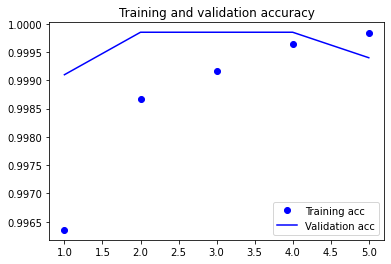

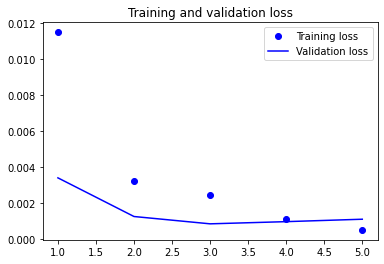

In [45]:
#Visualising the fine_tunign results
print("Accuracy after fine tuning")

acc_ft = history_FT.history['acc']
val_acc_ft = history_FT.history['val_acc']
loss_ft = history_FT.history['loss']
val_loss_ft = history_FT.history['val_loss']

epochs_ft = range(1, len(acc_ft) + 1)
plt.plot(epochs_ft, acc_ft, 'bo', label='Training acc')
plt.plot(epochs_ft, val_acc_ft, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.savefig("Training_Validation_acc_FN")
plt.figure()

plt.plot(epochs_ft, loss_ft, 'bo', label='Training loss')
plt.plot(epochs_ft, val_loss_ft, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("Training_Validation_loss_FN")

plt.show()

In [46]:
# Evaluating the model
model.evaluate(Test_data)

16/16 [==============================] - 231s 14s/step - loss: 1.9937 - acc: 0.6819


[1.9936777353286743, 0.681884765625]

In [47]:
#Saving the fine_tuned model
model.save('Fine_tuned_Xception.h5')